# Vaccine Sentiment Classification
*by Nefeli Tavoulari*

#### In this notebook I classify tweets as Neutral, Pro-vax or Anti-vax.

# Import Packages

In [56]:
%matplotlib inline
import io
import re
import csv
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 

from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import LancasterStemmer
porter = PorterStemmer()
lancaster = LancasterStemmer()
snowball = SnowballStemmer('english')
#from sklearn.model_selection import GridSearchCV
#from sklearn.preprocessing import StandardScaler, RobustScaler

import sklearn as sk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
from wordcloud import WordCloud

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer, HashingVectorizer
from sklearn.model_selection import learning_curve, ShuffleSplit
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, accuracy_score, mean_absolute_error
from sklearn.metrics import f1_score

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Upload dataset - Create dataframe

In [5]:
upload_train = files.upload()

Saving vs_train.csv to vs_train (2).csv


In [6]:
upload_dev = files.upload()

Saving vs_dev.csv to vs_dev (2).csv


In [47]:
df = pd.read_csv(io.BytesIO(upload_train['vs_train.csv']))
df2 = pd.read_csv(io.BytesIO(upload_dev['vs_dev.csv']))

In [48]:
print(df) # training data

       Unnamed: 0                                              tweet  label
0               0  Sip N Shop Come thru right now #Marjais #Popul...      0
1               1  I don't know about you but My family and I wil...      1
2               2  @MSignorile Immunizations should be mandatory....      2
3               3  President Obama spoke in favor of vaccination ...      0
4               4  "@myfoxla: Arizona monitoring hundreds for mea...      0
...           ...                                                ...    ...
15971       15971  @Salon if u believe the anti-vax nutcases caus...      1
15972       15972  How do you feel about parents who don't #vacci...      0
15973       15973  70 Preschoolers Tested for Measles in Simi Val...      0
15974       15974  Finance Minister: Budget offers room to procur...      0
15975       15975  Are you up to date on vaccines? Take CDC’s vac...      2

[15976 rows x 3 columns]


In [49]:
print(df2)  # validation data

      Unnamed: 0                                              tweet  label
0              0  @user They had a massive surge in with covid d...      1
1              1  Required vaccines for school: Parents and guar...      0
2              2  “@KCStar: Two more Johnson County children hav...      0
3              3  NV can do better. Which states are the best (a...      2
4              4  Nothing like killing ourselves w/ our own fear...      2
...          ...                                                ...    ...
2277        2277  RT @abc7: Number of measles cases reported in ...      0
2278        2278  Evidence points to the idea that "measles affe...      0
2279        2279  Where's @SavedYouAClick "@voxdotcom: Why you s...      2
2280        2280  Some of my favorite people have autism. If tha...      2
2281        2281  Coronavirus: The married couple behind the suc...      0

[2282 rows x 3 columns]


# Remove empty / duplicate tweets

In [50]:
df.dropna(subset = ["tweet"], inplace=True)
df.drop_duplicates(subset = ["tweet"], inplace=True)

df2.dropna(subset = ["tweet"], inplace=True)

print(df.shape)
print(df2.shape)

(15881, 3)
(2282, 3)


## Check dataset balance



In [51]:
df.groupby("label")["tweet"].count()

label
0    7385
1    2070
2    6426
Name: tweet, dtype: int64

In [52]:
stats = [["Neutral", df.groupby("label")["tweet"].count()[0]], ["Anti-vax", df.groupby("label")["tweet"].count()[1]], ["Pro-vax", df.groupby("label")["tweet"].count()[2]]]

Text(0.5, 1.0, 'Number of tweets per category')

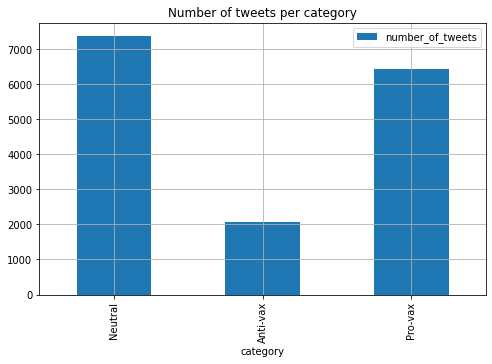

In [53]:
df_stats = pd.DataFrame(stats, columns=['category', 'number_of_tweets'])
df_stats.plot(x='category', y='number_of_tweets', kind='bar', grid=True, figsize=(8, 5))
plt.title("Number of tweets per category")

# Text Preprocessing

In [124]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):

  text = text.lower()                                           # lowercase
  text = text.strip()                                           # remove white spaces
  text = ' '.join(re.sub("(@[A-Za-z0-9]+)"," ",text).split())   # remove twitter user accounts
  text = re.sub(r'http\S+', ' ', text)                          # remove urls
  text = re.sub('[^A-Za-z0-9]+', ' ', text)                     # remove special characters

  # perform stemming
  cleaned_text = ""
  for word in text.split() :
    if word in stop_words:                                      # remove stopwords
      continue
    temp = lemmatizer.lemmatize(word)                           # lemmatize
    #temp = snowball.stem(word)
    #temp = lancaster.stem(word)
    #temp = porter.stem(word)
    
    cleaned_text += (temp + " ")

  return cleaned_text


In [125]:
cleaned_text = []                                  # clean training data
for line in df["tweet"]:
  cleaned_text.append(clean_text(line))
cleaned_text_val = []                              # clean validation data
for line in df2["tweet"]:
  cleaned_text_val.append(clean_text(line))

# Create new column with clean text

In [126]:
df = df.assign(clean_tweet = lambda x: cleaned_text)
df2 = df2.assign(clean_tweet = lambda x: cleaned_text_val)

In [127]:
df

,Unnamed: 0,tweet,label,clean_tweet
0,0,Sip N Shop Come thru right now #Marjais #Popul...,0,sip n shop come thru right marjais popularnobo...
1,1,I don't know about you but My family and I wil...,1,know family take covid19 vaccine anytime soon
2,2,@MSignorile Immunizations should be mandatory....,2,immunization mandatory period oklahoma let kid...
3,3,President Obama spoke in favor of vaccination ...,0,president obama spoke favor vaccination child ...
4,4,"""@myfoxla: Arizona monitoring hundreds for mea...",0,arizona monitoring hundred measles linked disn...
...,...,...,...,...
15971,15971,@Salon if u believe the anti-vax nutcases caus...,1,u believe anti vax nutcase caused measles u ig...
15972,15972,How do you feel about parents who don't #vacci...,0,feel parent vaccinate kid measlesoutbreak
15973,15973,70 Preschoolers Tested for Measles in Simi Val...,0,70 preschooler tested measles simi valley
15974,15974,Finance Minister: Budget offers room to procur...,0,finance minister budget offer room procure cov...


In [128]:
df2

,Unnamed: 0,tweet,label,clean_tweet
0,0,@user They had a massive surge in with covid d...,1,massive surge covid death immediately vaccine ...
1,1,Required vaccines for school: Parents and guar...,0,required vaccine school parent guardian child ...
2,2,“@KCStar: Two more Johnson County children hav...,0,two johnson county child measles
3,3,NV can do better. Which states are the best (a...,2,nv better state best worst vaccinating kid
4,4,Nothing like killing ourselves w/ our own fear...,2,nothing like killing w fear mt milano vaccine ...
...,...,...,...,...
2277,2277,RT @abc7: Number of measles cases reported in ...,0,rt number measles case reported cali 10 year h...
2278,2278,"Evidence points to the idea that ""measles affe...",0,evidence point idea measles affect immune syst...
2279,2279,"Where's @SavedYouAClick ""@voxdotcom: Why you s...",2,vaccinate kid two minute
2280,2280,Some of my favorite people have autism. If tha...,2,favorite people autism reason bringing back di...


# Vectorize and Perform TF-IDF

## Using CountVectorizer

### Concatenate dataframes to add every word to Vector

In [129]:
total = df.append(df2)
total.shape

(18163, 4)

### Training data

In [113]:
cv = CountVectorizer(stop_words='english',  max_df = 0.999, min_df = 0.001)     # exclude too rare or too typical words, because they offer no knowledge
word_count = cv.fit_transform(total['clean_tweet'])
word_count.shape

(18163, 16144)

In [114]:
tfidf_transformer = TfidfTransformer() 
tfidf_transformer.fit(word_count)

# print idf values sorted by ascending order - simply for debugging
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names_out(), columns=["idf_weights"]) 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
vaccin,1.471811
measl,2.347209
kid,3.182090
get,3.192392
immun,3.251815
...,...
immunitybuild,10.114050
immunitypassport,10.114050
immuniz,10.114050
imho,10.114050


In [115]:
word_count_train = cv.transform(df['clean_tweet']) 

# tf-idf scores 
tf_idf_vector = tfidf_transformer.transform(word_count_train)

In [116]:
# get tf-idf vector for first tweet 
first_tweet_vector = tf_idf_vector[0] 
 
# print scores sorted by descending order - for debugging
df3 = pd.DataFrame(first_tweet_vector.T.todense(), index=cv.get_feature_names_out() , columns=["tfidf"]) 
df3.sort_values(by=["tfidf"], ascending=False)

,tfidf
marjai,0.626431
sip,0.362966
sipnshop,0.362966
popularnobodi,0.313216
shop,0.293133
...,...
ferguson,0.000000
fergusonshoot,0.000000
ferm,0.000000
fernthebarb,0.000000


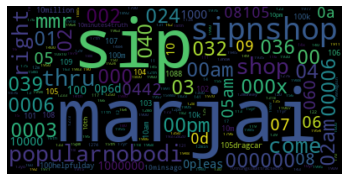

In [117]:
freq = {}
count = 0
for x in df3['tfidf']:
    freq[df3.index[count]] = x + 1
    count += 1
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=freq)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
# the most "important" words

### Test Data

In [118]:
word_count_dev = cv.transform(df2['clean_tweet']) 
tf_idf_vector_dev = tfidf_transformer.transform(word_count_dev)

# for debugging
first_document_vector_dev = tf_idf_vector_dev[0] 
df4 = pd.DataFrame(first_document_vector_dev.T.todense(), index=cv.get_feature_names_out(), columns=["tfidf"]) 
df4.sort_values(by=["tfidf"], ascending=False)

,tfidf
death,0.385014
entireti,0.378061
immedi,0.318075
surg,0.304186
rollout,0.297086
...,...
ferm,0.000000
fernthebarb,0.000000
ferret,0.000000
fest,0.000000


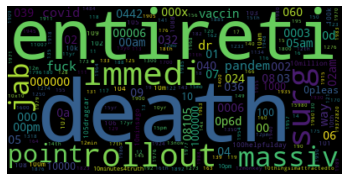

In [119]:
freq = {}
count = 0
for x in df4['tfidf']:
    freq[df4.index[count]] = x + 1
    count += 1
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=freq)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
# the most "important" words

### Perform Logistic Regression

In [120]:
x_train = pd.DataFrame.sparse.from_spmatrix(tf_idf_vector)
x_dev = pd.DataFrame.sparse.from_spmatrix(tf_idf_vector_dev)
y_train = df["label"]
y_dev = df2["label"]
x_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,16104,16105,16106,16107,16108,16109,16110,16111,16112,16113,16114,16115,16116,16117,16118,16119,16120,16121,16122,16123,16124,16125,16126,16127,16128,16129,16130,16131,16132,16133,16134,16135,16136,16137,16138,16139,16140,16141,16142,16143
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
x_total = x_train.append(x_dev)
y_total = y_train.append(y_dev)

In [122]:
LR = LogisticRegression(multi_class='multinomial', max_iter = 1000, C=1.5)
LR.fit(x_train, y_train)
y_train_pred = LR.predict(x_train) 
y_dev_pred = LR.predict(x_dev) 

### Evaluation metrics

In [123]:
print("Precision-Recall-F1 - Training Data :")
print(precision_recall_fscore_support(y_train, y_train_pred, average='micro'))
print()
print("Precision-Recall-F1 - Test Data :")
print(precision_recall_fscore_support(y_dev, y_dev_pred, average='micro'))
print()
print("Accuracy - Training Data :")
print(accuracy_score(y_train, y_train_pred))
print()
print("Accuracy - Test Data :")
print(accuracy_score(y_dev, y_dev_pred))

Precision-Recall-F1 - Training Data :
(0.8214218248221145, 0.8214218248221145, 0.8214218248221145, None)

Precision-Recall-F1 - Test Data :
(0.7094653812445223, 0.7094653812445223, 0.7094653812445223, None)

Accuracy - Training Data :
0.8214218248221145

Accuracy - Test Data :
0.7094653812445223


In [ ]:
cm = confusion_matrix(y_train, y_train_pred, labels=LR.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LR.classes_)
disp.plot()
plt.show()

In [ ]:
target_names = ['neutral', 'anti-vax', 'pro-vax']
print(classification_report(y_train, y_train_pred, target_names=target_names))
print(classification_report(y_dev, y_dev_pred, target_names=target_names))

In [ ]:
print("MAE - training : ", mean_absolute_error(y_train, y_train_pred))
print("MAE - testing : ", mean_absolute_error(y_dev, y_dev_pred))

In [ ]:
y_prob = LR.predict_proba(x_dev)

macro_roc_auc_ovo = roc_auc_score(y_dev, y_prob, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(
    y_dev, y_prob, multi_class="ovo", average="weighted"
)
macro_roc_auc_ovr = roc_auc_score(y_dev, y_prob, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(
    y_dev, y_prob, multi_class="ovr", average="weighted"
)
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)

### Plots

In [ ]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring='f1_micro',
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, "o-")
    axes[2].fill_between(
        fit_times_mean,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = LogisticRegression(multi_class='multinomial', max_iter = 1000, C=1.5)
plot_learning_curve(estimator, title, x_total, y_total, axes=axes[:], ylim=(0.4, 1.0), cv=cv, n_jobs=4)

plt.show()

In [ ]:
# from sklearn.linear_model import LogisticRegressionCV
# LRCV = LogisticRegressionCV(multi_class='multinomial', max_iter = 1000,  cv=10)
# LRCV.fit(x_total, y_total)
# y_train_pred = LRCV.predict(x_train) 
# y_dev_pred = LRCV.predict(x_dev) 

# print("Precision-Recall-F1 - Training Data :")
# print(precision_recall_fscore_support(y_train, y_train_pred, average='micro'))
# print()
# print("Precision-Recall-F1 - Test Data :")
# print(precision_recall_fscore_support(y_dev, y_dev_pred, average='micro'))
# print()
# print("Accuracy - Training Data :")
# print(accuracy_score(y_train, y_train_pred))
# print()
# print("Accuracy - Test Data :")
# print(accuracy_score(y_dev, y_dev_pred))

## Using HashingVectorizer

In [138]:
total = df.append(df2)
hv = HashingVectorizer(n_features=2**15, stop_words="english", ngram_range=(1,2))
tfidf_transformer = TfidfTransformer() 

word_count = hv.fit_transform(total['clean_tweet'])
tfidf_transformer.fit(word_count)

word_count_train = hv.transform(df['clean_tweet']) 
word_count_dev = hv.transform(df2['clean_tweet']) 

tf_idf_vector = tfidf_transformer.transform(word_count_train)
tf_idf_vector_dev = tfidf_transformer.transform(word_count_dev)

x_train = pd.DataFrame.sparse.from_spmatrix(tf_idf_vector)
x_dev = pd.DataFrame.sparse.from_spmatrix(tf_idf_vector_dev)
y_train = df["label"]
y_dev = df2["label"]
x_total = x_train.append(x_dev)
y_total = y_train.append(y_dev)

LR = LogisticRegression(multi_class='multinomial', max_iter = 1000, C=1.9, penalty='elasticnet', solver='saga', l1_ratio=0.4)

LR.fit(x_train, y_train)

y_train_pred = LR.predict(x_train) 
y_dev_pred = LR.predict(x_dev) 

### Evaluation Metrics


In [139]:
print("Precision-Recall-F1 - Training Data :")
print(precision_recall_fscore_support(y_train, y_train_pred, average='micro'))
print()
print("Precision-Recall-F1 - Test Data :")
print(precision_recall_fscore_support(y_dev, y_dev_pred, average='micro'))
print()
print("Accuracy - Training Data :")
print(accuracy_score(y_train, y_train_pred))
print()
print("Accuracy - Test Data :")
print(accuracy_score(y_dev, y_dev_pred))

Precision-Recall-F1 - Training Data :
(0.8535986398841383, 0.8535986398841383, 0.8535986398841383, None)

Precision-Recall-F1 - Test Data :
(0.7296231375985978, 0.7296231375985978, 0.7296231375985978, None)

Accuracy - Training Data :
0.8535986398841383

Accuracy - Test Data :
0.7296231375985978


In [ ]:
cm = confusion_matrix(y_train, y_train_pred, labels=LR.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LR.classes_)
disp.plot()
plt.show()

In [ ]:
target_names = ['neutral', 'anti-vax', 'pro-vax']
print(classification_report(y_train, y_train_pred, target_names=target_names))
print(classification_report(y_dev, y_dev_pred, target_names=target_names))

In [ ]:
print("MAE - training : ", mean_absolute_error(y_train, y_train_pred))
print("MAE - testing : ", mean_absolute_error(y_dev, y_dev_pred))

### Plots

In [ ]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,0.7169
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring='f1_micro',
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, "o-")
    axes[2].fill_between(
        fit_times_mean,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = LogisticRegression(multi_class='multinomial', max_iter = 1000, C=1.5)
plot_learning_curve(estimator, title, x_total, y_total, axes=axes[:], ylim=(0.4, 1.0), cv=cv, n_jobs=4)

plt.show()

## Using TfidfVectorizer

In [140]:
total = df.append(df2)
tfidfvectorizer = TfidfVectorizer(stop_words='english', max_df = 0.999, min_df = 0.001)

word_count = tfidfvectorizer.fit_transform(total['clean_tweet'])
word_count_train = tfidfvectorizer.transform(df['clean_tweet'])
word_count_dev = tfidfvectorizer.transform(df2['clean_tweet'])

x_train = pd.DataFrame.sparse.from_spmatrix(word_count_train)
x_dev = pd.DataFrame.sparse.from_spmatrix(word_count_dev)
y_train = df["label"]
y_dev = df2["label"]

#scaler = StandardScaler(with_mean=False, with_std=False)
#scaler = RobustScaler(with_centering=False)
#x_train = scaler.fit_transform(x_train)
#x_dev = scaler.transform(x_dev)


# parameters={'penalty':['l2','none'],'C':[1.2, 1.3, 1.4, 1.5, 1.9, 2.0], 'solver':['newton-cg', 'lbfgs', 'sag', 'saga'], 'multi_class':['multinomial'], 'max_iter':[500, 1000]}
# gscv = GridSearchCV(LR, parameters, scoring='accuracy', n_jobs=-1, cv=10)
# grid_search = gscv.fit(x_train, y_train)
# print(grid_search.best_params_)

LR = LogisticRegression(multi_class='multinomial', max_iter = 1000, C=1.5)

LR.fit(x_train, y_train)

y_train_pred = LR.predict(x_train) 
y_dev_pred = LR.predict(x_dev) 

### Evaluation metrics

In [141]:
print("Precision-Recall-F1 - Training Data :")
print(precision_recall_fscore_support(y_train, y_train_pred, average='micro'))
print()
print("Precision-Recall-F1 - Test Data :")
print(precision_recall_fscore_support(y_dev, y_dev_pred, average='micro'))
print()
print("Accuracy - Training Data :")
print(accuracy_score(y_train, y_train_pred))
print()
print("Accuracy - Test Data :")
print(accuracy_score(y_dev, y_dev_pred))

Precision-Recall-F1 - Training Data :
(0.764372520622127, 0.764372520622127, 0.7643725206221271, None)

Precision-Recall-F1 - Test Data :
(0.7230499561787905, 0.7230499561787905, 0.7230499561787904, None)

Accuracy - Training Data :
0.764372520622127

Accuracy - Test Data :
0.7230499561787905


In [ ]:
cm = confusion_matrix(y_train, y_train_pred, labels=LR.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LR.classes_)
disp.plot()
plt.show()

In [ ]:
target_names = ['neutral', 'anti-vax', 'pro-vax']
print(classification_report(y_train, y_train_pred, target_names=target_names))
print(classification_report(y_dev, y_dev_pred, target_names=target_names))

### Plots

In [ ]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
        scoring='f1_micro',
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, "o-")
    axes[2].fill_between(
        fit_times_mean,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 1, figsize=(10, 15))

title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = LogisticRegression(multi_class='multinomial', max_iter = 1000, C=1.5)
plot_learning_curve(estimator, title, x_total, y_total, axes=axes[:], ylim=(0.4, 1.0), cv=cv, n_jobs=4)

plt.show()